# Ερώτηση 3 (Clustering)

## Loading data

In [1]:
import pandas as pd
import numpy as np
import json
import time 

yelp_dataset_path = '../yelp-dataset/'
buisness_v_path = yelp_dataset_path + 'yelp_academic_dataset_business.json'
leftK_path = '/home/left/Desktop/dataMining/set2/ask2/yelp_academic_dataset_business.json'

dataset_business = []
categories_order = ["Beauty & Spas", "Shopping", "Bars"]

start = time.time()

with open(buisness_v_path, 'r', encoding="utf8") as buisness_file:
    for line in buisness_file:
        json_dict = json.loads(line)
        if  json_dict['city'] == 'Toronto' and \
            json_dict['review_count'] > 10 and \
            json_dict['categories'] is not None and \
            any(word in json_dict['categories'] for word in categories_order):
                temp_cat = [cat for cat in categories_order if cat in json_dict['categories']][0]
                dataset_business.append([json_dict['business_id'], temp_cat])
                

stop = time.time()
print("Read file in {} seconds".format(stop-start))

Read file in 3.813101291656494 seconds


In [2]:
np_business = np.array(dataset_business)
np_business_id = np_business[:,0]

In [3]:
def get_index(business_id):
    index = np.where(np_business_id == business_id)[0]
    return index

In [4]:
start = time.time()
business_review_txt = [[] for i in range(int(len(np_business)))]
review_v_path = yelp_dataset_path + 'yelp_academic_dataset_review.json'
leftK_path = '/home/left/Desktop/dataMining/set2/ask2/yelp_academic_dataset_review.json'

with open(review_v_path, 'r', encoding="utf8") as reviews_file:
    for line in reviews_file:
        json_dict = json.loads(line)
        index = get_index(json_dict['business_id'])
        if index.size > 0:
            if len(business_review_txt[index[0]]) == 0:
               business_review_txt[index[0]] = json_dict['text']
            else:
               business_review_txt[index[0]] += json_dict['text']
        # if json_dict['business_id'] in np_business:
        #     if json_dict['business_id'] in business_review_txt:
        #         business_review_txt[json_dict['business_id']] += json_dict['text']
        #     else:
        #         business_review_txt[json_dict['business_id']] = json_dict['text']


stop = time.time()

print("Read file in {} mins".format((stop-start)/60))

Read file in 5.447769939899445 mins


## TF-IDF

In [65]:
from sklearn.feature_extraction import text

def preprocessor(text):
    text=text.lower() 
    text=re.sub("\\W"," ",text) # remove special chars
    text=re.sub("\\s+(in|the|all|for|and|on)\\s+"," _connector_ ",text) # normalize certain words
    return text
    
with open('stopwords.txt', 'r') as text_file:
    lines = text_file.read().split('\n')

stop_words = lines

In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_df = 0.50,
                        min_df = 0.25,
                        max_features = 50000,
                        stop_words = stop_words)
tfidf.fit(business_review_txt)
fitted_vectorizer = tfidf.transform(business_review_txt)

In [81]:
# show words that were eliminated
df_idf = pd.DataFrame(tfidf.idf_, index=tfidf.get_feature_names(),columns=["idf_weights"]) 
df_idf.sort_values(by=['idf_weights']) 

,idf_weights
including,1.693147
entire,1.694986
wonderful,1.696214
music,1.696828
received,1.696828
...,...
eventually,2.380798
brown,2.380798
fall,2.383237
walls,2.384459


In [82]:
# show words that are included
tfidf.vocabulary_

{'checked': 98,
 'restaurant': 474,
 'parking': 400,
 'served': 508,
 'low': 321,
 '11': 2,
 'arrive': 35,
 'early': 171,
 'prepared': 437,
 'slightly': 529,
 'cooked': 128,
 'piece': 414,
 'turn': 608,
 'dry': 168,
 'bland': 59,
 'rare': 455,
 'ambiance': 22,
 'event': 184,
 'classic': 109,
 'building': 77,
 'spent': 545,
 'odd': 380,
 'haven': 258,
 'heard': 261,
 'dinner': 153,
 '100': 1,
 'choices': 106,
 'treat': 601,
 'birthday': 56,
 'complaints': 122,
 'waiter': 622,
 'dessert': 149,
 'choice': 105,
 'meal': 330,
 'bowl': 68,
 'salad': 486,
 'server': 509,
 'average': 42,
 'tender': 582,
 'chicken': 102,
 'anyways': 27,
 'grilled': 247,
 'canadian': 83,
 'complain': 120,
 'seriously': 506,
 'tonight': 595,
 'efficient': 175,
 'seated': 498,
 'pleasant': 422,
 'orders': 391,
 'ready': 459,
 'plates': 419,
 'perfectly': 407,
 'stay': 552,
 'coffee': 114,
 'game': 230,
 'group': 248,
 'bread': 72,
 'welcoming': 635,
 'taking': 570,
 'green': 245,
 'potato': 435,
 'meals': 331,
 'b

## Kmeans

In [83]:
from sklearn.cluster import KMeans
import sklearn.cluster as sk_cluster
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

kmeans = sk_cluster.KMeans(n_clusters=3)
kmeans.fit_predict(fitted_vectorizer)
y_pred = kmeans.labels_
centroids = kmeans.cluster_centers_
error = kmeans.inertia_

Total error: 2265.671901384297
Cluster Centroids: 
[[0.01326586 0.01897277 0.01012109 ... 0.01262662 0.01421921 0.00336427]
 [0.00726628 0.01204734 0.00383957 ... 0.00769933 0.00783467 0.00032259]
 [0.01063817 0.00770124 0.014099   ... 0.00675935 0.00871784 0.02035514]]


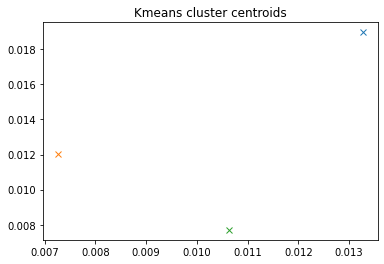

In [84]:
# General information
print("Total error: {}".format(error))
print("Cluster Centroids: \n{}".format(centroids))

for centroids in kmeans.cluster_centers_:
    plt.plot(centroids[0], centroids[1], marker='x')
plt.title('Kmeans cluster centroids')
plt.show()

0: 1705, 1: 757, 2: 803, sum: 3265
Confusion matrix : 
[[ 251    0 1454]
 [ 473  282    2]
 [ 770    0   33]]


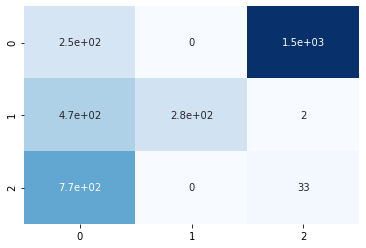

Precision : [0.16800535 1.         0.02216253]
Recall : [0.14721408 0.37252312 0.04109589]


In [85]:
# True values table: Μatching categories to numbers
true_labels = np_business[:,1]
for i in range(len(true_labels)):
    if true_labels[i]=='Bars':
        true_labels[i]=0
    if true_labels[i]=='Beauty & Spas':
        true_labels[i]=1
    if true_labels[i]=='Shopping':
        true_labels[i]=2
    
true_labels = [int(i) for i in true_labels] 
n0 = true_labels.count(0)
n1 = true_labels.count(1)
n2 = true_labels.count(2)
print('0: {}, 1: {}, 2: {}, sum: {}'.format(n0, n1, n2, n0+n1+n2))

# Confusion matrix
cf_matrix = confusion_matrix(true_labels, y_pred)

print("Confusion matrix : \n{}".format(cf_matrix))
sns.heatmap(cf_matrix,  annot=True, 
                        cmap='Blues',
                        cbar=False)
plt.show()

# Precision - Recall
precision = metrics.precision_score(true_labels, y_pred, average=None)
recall = metrics.recall_score(true_labels, y_pred, average = None)

print("Precision : {}".format(precision))
print("Recall : {}".format(recall))


[2, 1, 0]
Confusion matrix : 
[[1454    0  251]
 [   2  282  473]
 [  33    0  770]]


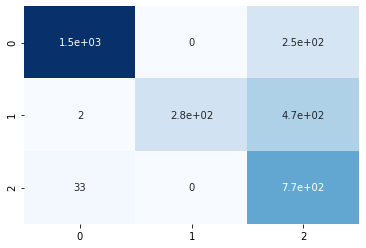

Precision : [0.16800535 1.         0.02216253]
Recall : [0.14721408 0.37252312 0.04109589]


In [86]:
# x_axis_labels = ['Bars', 'Beauty & Spas', 'Shopping'] 
# y_axis_labels = [0, 1, 2] 
# ,
#                         xticklabels=x_axis_labels, 
#                         yticklabels=y_axis_labels

mapping = list(np.argmax(cf_matrix, axis=0))
print(mapping)

mapped_kmeans_labels = [0 for i in range(len(y_pred))]
for i in range(len(y_pred)):
    mapped_kmeans_labels[i] = mapping[y_pred[i]]

cf_matrix = confusion_matrix(true_labels, mapped_kmeans_labels)
print("Confusion matrix : \n{}".format(cf_matrix))
sns.heatmap(cf_matrix,  annot=True, 
                        cmap='Blues',
                        cbar=False)
plt.show()

# Precision - Recall
precision = metrics.precision_score(true_labels, y_pred, average=None)
recall = metrics.recall_score(true_labels, y_pred, average = None)

print("Precision : {}".format(precision))
print("Recall : {}".format(recall))


Clusters 2, score 0.100
Clusters 3, score 0.120
Clusters 4, score 0.098
Clusters 5, score 0.102
Clusters 6, score 0.094
Clusters 7, score 0.098


Text(0, 0.5, 'Error')

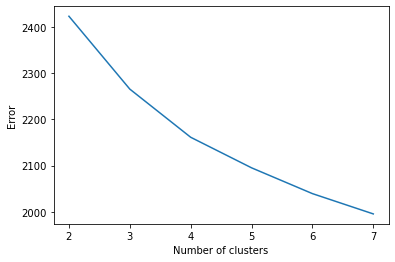

In [87]:
from sklearn.metrics import silhouette_score

n_clusters = 7
error = np.zeros(n_clusters+1)
error[0] = 0
max_score = 0
f_clasters = 0
#sc = np.zeros(n_clusters+1)
for k in range(2,n_clusters+1):
    kmeans = sk_cluster.KMeans(n_clusters=k, init='k-means++')
    preds = kmeans.fit_predict(fitted_vectorizer)
    error[k] = kmeans.inertia_
    score = silhouette_score(fitted_vectorizer, preds)
    print('Clusters {}, score {:.3f}'.format(k, score))
    if (score > max_score):
        f_clasters = k 
        max_score = score

plt.plot(range(2,len(error)),error[2:])
plt.xlabel('Number of clusters')
plt.ylabel('Error')

In [88]:
# from sklearn.metrics import silhouette_samples, silhouette_score

# for n_clusters in range(2, 11):
#     kmeans = KMeans(n_clusters=n_clusters)
#     cluster_labels = kmeans.fit_predict(fitted_vectorizer)

#     silhouette_avg = silhouette_score(fitted_vectorizer, cluster_labels)
#     print("For n_clusters =", n_clusters,
#             "The average silhouette_score is :", silhouette_avg)

In [89]:
# data_for_agglo = fitted_vectorizer.todense()

# from sklearn.cluster import AgglomerativeClustering
# agglomerative = sk_cluster.AgglomerativeClustering(n_clusters=3, linkage='ward')
# predictions = agglomerative.fit_predict(data_for_agglo)


# # MAKE CONF MATRIX HERE FOR 'WARD' PREC/REC ETC.

In [90]:
# agglomerative = sk_cluster.AgglomerativeClustering(n_clusters=3, linkage='complete')
# predictions = agglomerative.fit_predict(data_for_agglo)

# MAKE CONF MATRIX HERE FOR ;COMPLETE' PREC/REC ETC.

In [91]:
# agglomerative = sk_cluster.AgglomerativeClustering(n_clusters=3, linkage='average')
# predictions = agglomerative.fit_predict(data_for_agglo)

# MAKE CONF MATRIX HERE FOR 'AVERAGE' PREC/REC ETC.

In [92]:
# agglomerative = sk_cluster.AgglomerativeClustering(n_clusters=3, linkage='single')
# predictions = agglomerative.fit_predict(data_for_agglo)

# # MAKE CONF MATRIX HERE FOR 'SINGLE' PREC/REC ETC.

In [93]:
# print(predictions)